# **Recurrent Neural Network - Analyse de sentiments**

Le but de cet exercice est la classification binaire (positive ou négative) de reviews en utilisant un RNN sur un dataset de commentaires IMDB que vous trouverez dans le dossier data.

In [47]:
import string
import pandas as pd
import numpy as np

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential

## **1. Import des données et preprocessing**

1. Importer les 2 fichiers ".txt" de data/imdb
2. Vérifier ce qu'il y a dedans si c'est pas déjà fait...
3. Un peu de preprocessing de texte, allez on va chercher dans sa petite mémoire et sinon dans son gros ordinateur :
>- convertir en minuscules
>- retirer la ponctuation
>- créer une liste des reviews et déterminer combien il y en a. Pareil pour les labels. Inch'Allah y en aura autant.

In [2]:
# import des txt
with open('data/imdb/reviews.txt', 'r') as f:
    reviews_str = f.read()
with open('data/imdb/labels.txt', 'r') as f:
    labels_str = f.read()

In [3]:
type(reviews_str), len(reviews_str), reviews_str[:900]

(str,
 33678267,
 'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   \nstory of a man who has unnatural feelings for a pig . starts out wi')

In [4]:
type(labels_str), len(labels_str), labels_str[:100]

(str,
 225000,
 'positive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nn')

In [5]:
# nettoyage des string
reviews_str = reviews_str.lower()
reviews_str = reviews_str.translate(str.maketrans('', '', string.punctuation))
reviews_str[:900]

'bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t   \nstory of a man who has unnatural feelings for a pig  starts out with a opening scene that is a'

In [6]:
rvws = reviews_str.splitlines()
lbls = labels_str.splitlines()
len(rvws), len(lbls)

(25000, 25000)

## **2. Tokenisation ou encodage**

Le but est de remplacer les mots des reviews par des entiers. Si vous voulez faire à votre sauce, vous y êtes encouragés !

Sinon, les quelques étapes décrites ci-dessous vous permettront de le faire :
>- compter l'ensemble des mots (vous pouvez utiliser `Counter` de la librairie `collections` qui est une des plus rapide dans ce domaine)
>- les trier par ordre décroissant d'occurrences
>- créer un dictionnaire `word_mapping` où les clés sont les mots et les valeurs l'entier associé (votre dico doit être `{'the': 1, 'and': 2, 'a': 3, 'of': 4,..., 'muppified': 74070, 'whelk': 74071, 'hued': 74072}`). C'est volontaire que ça commence à 1 car on utilisera le "0" comme caractère spécial (il servira pour "remplir" les reviews les plus courtes afin qu'elles aient toutes la même taille...)
>- encoder les mots (c'est-à-dire les remplacer par l'entier qui les représente)
>- encoder les labels (ça c'est fastoche, on se débrouille)

In [7]:
# comptage des mots et tri par occurences
words = reviews_str.split()
countWords = Counter(words)
sorted_words = sorted(countWords, key=countWords.get, reverse=True)

In [8]:
# dictionnaire de correspondance mot:entier
word_mapping = {w:i+1 for i,w in enumerate(sorted_words)}

In [9]:
# encodage des mots
rvws_num = [list(map(lambda w: word_mapping[w], rvw.split())) for rvw in rvws]

In [10]:
# taille max des reviews
max([len(rvw) for rvw in rvws_num])

2514

In [11]:
# encodage des labels
lbls_num = [1*(lab=="positive") for lab in lbls]

## **3. Longueur des séquences**

Il s'agit ici d'analyser la longueur des reviews pour déterminer éventuellement des outliers et choisir ce qu'on en fait. On va aussi "uniformiser" la longueur des séquence.

1. Avec la méthode de votre choix (graphique, stats desc...), étudier la longueur des reviews
2. Déterminer s'il y a des outliers et ce que vous souhaitez en faire (si vous les décidez de les supprimer, attention de bien supprimer aussi les labels correspondants...)
3. Ça a été évoqué un peu plus haut, on veut que nos reviews aient toutes la même taille pour faciliter l'entraînement du réseau. Par conséquent on va ajouter des 0 aux reviews les plus courtes et tronquer les reviews les plus longues (*padding/truncating*, si vous vous souvenez bien on a vu il y a peu le *zero-padding* dans un certain cas...bon ben c'est pareil).  
>- définir une fonction `trunc_pad(review_list, length)` :
>>- qui prend en paramètres la liste des reviews (chaque review étant encodée en une liste d'entiers) et une longueur donnée
>>- et qui retourne un array 2D avec (en ligne) les reviews trop longues tronquées et des 0 à gauche pour les reviews trop courtes. Avant de vous lancer et pour vous assurer d'avoir compris, quelles dimensions doit avoir votre array en sortie ?
>>- tester votre fonction avec une longueur fixée à 250 et afficher les 5 premières valeurs des 5 premières reviews. Vous devez obtenir ça:
 
\[[    0     0     0     0     0]  
[    0     0     0     0     0]  
[22382    42 46418    15   706]  
[ 4505   505    15     3  3342]  
[    0     0     0     0     0]\]

>- maintenant, que c'est fait, je peux vous le dire, il y a une fonction dans `keras.preprocessing` qui permet de le faire. La trouver et comparer les temps d'éxecution des 2 fonctions.

count    25000.00000
mean       240.80784
std        179.01773
min         10.00000
5%          66.00000
10%         94.00000
25%        130.00000
50%        179.00000
75%        293.00000
90%        471.00000
95%        618.00000
max       2514.00000
dtype: float64


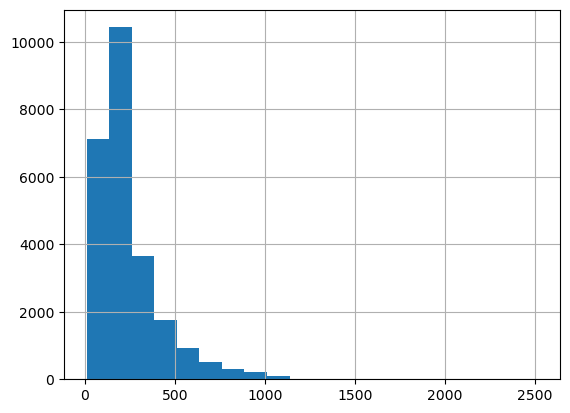

In [12]:
# longueur des reviews
rvws_len = pd.Series(map(len, rvws_num))
rvws_len.hist(bins=20);
print(rvws_len.describe(percentiles=[.05, .1, .25, .5, .75, .9, .95]))

In [13]:
# une analyse grossière de ces longueurs tend à vouloir couper les séquences entre 250 et 450
seq_len = 250

In [14]:
# fonction padding/truncating
def trunc_pad(review_list, length=300):
    res = np.zeros((len(review_list), length), dtype=int)
    for i, rvw in enumerate(review_list):
        res[i, -len(rvw):] = rvw[:length]
    return res

In [15]:
trunc_pad(rvws_num, length=seq_len)

array([[    0,     0,     0, ...,     8,   215,    23],
       [    0,     0,     0, ...,    29,   108,  3324],
       [22382,    42, 46418, ...,    13,   391,    22],
       ...,
       [    0,     0,     0, ..., 45313,  1175,   781],
       [    0,     0,     0, ...,    81,    95,    38],
       [    0,     0,     0, ...,    11,     6,  1321]])

In [16]:
%%time
X0 = pad_sequences(rvws_num, maxlen=seq_len, padding="pre", truncating="post")

CPU times: user 253 ms, sys: 4.1 ms, total: 257 ms
Wall time: 255 ms


In [17]:
%%time
X = trunc_pad(rvws_num, length=seq_len)

CPU times: user 244 ms, sys: 8.43 ms, total: 252 ms
Wall time: 252 ms


## **4. Échantillons d'entraînement, de validation et de test**

Découper les données en train, validation et test sets de la manière qui vous plaira. Tant que c'est juste et cohérent bien sûr.  
Il faut qu'il y ait 20000 observations dans le train, 2500 dans le validation et 2500 dans le test. 

In [18]:
y = np.array(lbls_num)
X.shape, y.shape

((25000, 250), (25000,))

In [19]:
%%time
# avec sklearn, en 2 fois
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=2500)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=2500)

CPU times: user 6.52 ms, sys: 24.4 ms, total: 30.9 ms
Wall time: 29.8 ms


In [20]:
%%time
# à la main
idx_shuffled = np.arange(25000)
np.random.shuffle(idx_shuffled)

X_shuffled = X[idx_shuffled]
y_shuffled = y[idx_shuffled]

nb_tr, nb_val = 20000, 2500

X_train, X_val, X_test = X_shuffled[:nb_tr], X_shuffled[nb_tr:nb_tr+nb_val], X_shuffled[nb_tr+nb_val:]
y_train, y_val, y_test = y_shuffled[:nb_tr], y_shuffled[nb_tr:nb_tr+nb_val], y_shuffled[nb_tr+nb_val:]

CPU times: user 14.8 ms, sys: 4.21 ms, total: 19 ms
Wall time: 17.6 ms


In [21]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(20000, 250) (2500, 250) (2500, 250)
(20000,) (2500,) (2500,)


## **5. Petite paranthèse sur le _word embedding_**

Le [*word embedding*](https://fr.wikipedia.org/wiki/Word_embedding) consiste à transformer des mots sous forme de vecteurs de nombres. Bon ça on peut le faire relativement facilement, vous venez d'ailleurs de le faire avec la représentation du lexique des reviews en nombres entiers. Pour passer à un vecteur il suffirait juste de faire un one-hot-encoding.

Il y a plusieurs problèmes à cette solution (même si on l'utilise parfois dans du NLP simple) :
- la dimension de l'espace engendré
- l'absence totale de notion de similarité (avec la représentation one-hot, 2 mots qui n'ont rien à voir sont aussi différents que 2 mots tout à fait synonyme)
- le fait que les vecteurs contiennent quasiment que des 0 (sparse matrix)
- le fait que les modèles sont ensuite difficilement généralisable car en cas de nouveau mot, le modèle ne sait pas du tout les traiter puisqu'il ne peut pas du tout les comparer aux mots vus dans l'entraînement

Donc le *word embedding* s'attaque à ce problème avec pour objectifs de :
1. représenter les mots sous forme de vecteurs de nombres réels (et non entiers, on passe donc à un espace continu et plus discret)
2. conserver la notion de similarité c'est-à-dire que 2 vecteurs qui sont proches doivent représenter des mots "sémantiquement proches"
3. de les représenter dans un espace de plus petite dimension (en fonction de votre vocabulaire, soit le nombre de mots dans votre problème, ça peut aller très vite, généralement plusieurs milliers ou 10aines de milliers)

Le principe est de s'intéresser au contexte des mots, c'est-à-dire, quels mots sont associés ensemble en s'appuyant sur la co-occurrence.
Différents modèles de word embedding existent : [word2vec](https://fr.wikipedia.org/wiki/Word2vec), Glove, fasttext...

En pratique avec `keras`, que se passe-t-il lorsqu'on ajout une couche [*embedding*](https://keras.io/api/layers/core_layers/embedding/) ? Un exemple juste en dessous.

Un peu de visionnage pour y voir plus clair si ça vous intéresse :
- https://www.youtube.com/watch?v=Eku_pbZ3-Mw
- https://www.youtube.com/watch?v=oUpuABKoElw
- https://www.youtube.com/watch?v=5PL0TmQhItY

Et un peu de lecture :
- https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
- https://towardsdatascience.com/why-do-we-use-embeddings-in-nlp-2f20e1b632d2
- https://towardsdatascience.com/word-embeddings-for-nlp-5b72991e01d4
- https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf
- https://medium.com/rasa-blog/supervised-word-vectors-from-scratch-in-rasa-nlu-6daf794efcd8
- https://web.stanford.edu/~jurafsky/slp3/6.pdf

In [22]:
# on prend quelques phrases d'exemples pour illustrer le word embedding
t1 = "i hope to see you again"
t2 = "you wish to see me soon"
t3 = "i wish we will meet again"

In [25]:
# méthode mise en place au dessus
cnts = Counter(' '.join([t1,t2,t3]).split())
dico = {w:i+1 for i,w in enumerate(sorted(cnts, key=cnts.get, reverse=True))}
cnts, dico, len(dico)

(Counter({'i': 2,
          'to': 2,
          'see': 2,
          'you': 2,
          'again': 2,
          'wish': 2,
          'hope': 1,
          'me': 1,
          'soon': 1,
          'we': 1,
          'will': 1,
          'meet': 1}),
 {'i': 1,
  'to': 2,
  'see': 3,
  'you': 4,
  'again': 5,
  'wish': 6,
  'hope': 7,
  'me': 8,
  'soon': 9,
  'we': 10,
  'will': 11,
  'meet': 12},
 12)

In [24]:
# en représentant les vecteurs avec cette méthode on obtient
t_num = [[dico[w] for w in t.split()] for t in [t1, t2, t3]]
t_num

[[1, 7, 2, 3, 4, 5], [4, 6, 2, 3, 8, 9], [1, 6, 10, 11, 12, 5]]

In [26]:
# on crée un modèle avec un couche embedding
mod_emb = Sequential()
mod_emb.add(Embedding(input_dim=13, output_dim=2, input_length=6))
mod_emb.compile()
print(mod_emb.summary())

out1 = mod_emb.predict([t_num[0]])
out2 = mod_emb.predict([t_num[1]])
out3 = mod_emb.predict([t_num[2]])

print(out1, out2, out3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 2)              26        
                                                                 
Total params: 26 (104.00 Byte)
Trainable params: 26 (104.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
1/1 [==============================] - 0s 30ms/step
[[[ 0.04645086  0.00891704]
  [ 0.01984501  0.04939472]
  [ 0.02245485 -0.04839033]
  [-0.02122991 -0.00447623]
  [ 0.01027304 -0.00228689]
  [-0.01820822  0.04357253]]] [[[ 0.01027304 -0.00228689]
  [-0.04344643  0.00133214]
  [ 0.02245485 -0.04839033]
  [-0.02122991 -0.00447623]
  [-0.00037396 -0.02091723]
  [ 0.00826902 -0.0167303 ]]] [[[ 0.04645086  0.00891704]
  [-0.04344643  0.00133214]
  [-0.03547596 -0.03916921]
  [ 0.04676117  0.01137115]
  [ 0.0404445   0.00227646]
  [-0.01820

## **6. Création, entraînement et évaluation du modèle**

Créer un premier modèle, que vous serez tout à fait libre et même cordialement conviés à améliorer par la suite, avec :
- une couche Embedding
- une couche LSTM

In [27]:
# Construction du modèle
model = Sequential()
model.add(Embedding(input_dim=len(word_mapping)+1,
                    output_dim=64,
                    input_length=seq_len))
model.add(LSTM(units=200))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 64)           4740672   
                                                                 
 lstm (LSTM)                 (None, 200)               212000    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 4952873 (18.89 MB)
Trainable params: 4952873 (18.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=3)

Epoch 1/3
625/625 [==============================] - 187s 297ms/step - loss: 0.5146 - accuracy: 0.7501 - val_loss: 0.4455 - val_accuracy: 0.8068
Epoch 2/3
625/625 [==============================] - 210s 337ms/step - loss: 0.3058 - accuracy: 0.8789 - val_loss: 0.3545 - val_accuracy: 0.8620
Epoch 3/3
625/625 [==============================] - 215s 344ms/step - loss: 0.1714 - accuracy: 0.9408 - val_loss: 0.4430 - val_accuracy: 0.8456


In [29]:
# test du modèle
model.evaluate(X_test, y_test)

79/79 [==============================] - 7s 94ms/step - loss: 0.4661 - accuracy: 0.8372


[0.46605655550956726, 0.8371999859809875]

In [30]:
# vérification de la répartition des labels
np.mean(y), np.mean(y_train), np.mean(y_test), np.mean(y_val)

(0.5, 0.50035, 0.4888, 0.5084)

In [37]:
X_test.shape

(2500, 250)

In [46]:
# prédiction d'une review
review_test = rvws[idx_shuffled[22502]]
x_rvw_test = np.expand_dims(X[idx_shuffled[22502]], axis=0)
y_rvw_test = y[idx_shuffled[22502]]
pred = model.predict(x_rvw_test)
pred, y_rvw_test

1/1 [==============================] - 0s 42ms/step


(array([[0.9043721]], dtype=float32), 1)

In [41]:
# prédictions sur le test set
y_pred = model.predict(X_test)

79/79 [==============================] - 7s 94ms/step


In [48]:
# matrice de confusion
y_pred = 1 * (y_pred > 0.5)
confusion_matrix(y_test, y_pred)

array([[1146,  132],
       [ 275,  947]])